In [62]:
# Load from pkl files
import pandas as pd
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


with open('./Input/8-mers/mic_dframe.pkl', 'rb') as file:
    mic_dframe = pickle.load(file)
with open('./Input/8-mers/suscep_classes.pkl', 'rb') as file:
    suscep_classes = pd.read_pickle(file)

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

antibiotics = mic_dframe.columns[-12:]

def best_N_features(target_df, antibiotic, N):
    path = './input/8-mers/counts/'
    genome_ids = target_df['Genome ID'].loc[pd.notnull(target_df[antibiotic])].values
    X = np.array([np.load(path + genome_id + '.npy') for genome_id in genome_ids])
    y = target_df[antibiotic].loc[pd.notnull(target_df[antibiotic])].values
    n_best = SelectKBest(chi2, k=N)
    X_new = n_best.fit_transform(X, y*10**5)
    kmers = np.load('./input/8-mers/kmers_basis.npy')
    selected_kmers = [column[0]  for column in zip(kmers, n_best.get_support()) if column[1]]
    #scores = k_best.fit(X,y).scores_
    best_feature_df = pd.DataFrame(X_new, columns = selected_kmers)
    return best_feature_df

In [64]:
from sklearn.preprocessing import OneHotEncoder

antibiotic = 'ampicillin'

kmer_dframe = best_N_features(target_df=mic_dframe, antibiotic='ampicillin', N=1500)

# Features
X = kmer_dframe.values

# Standardize the input data
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)

# Target
# list of MIC values
y = mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].values

# reshape the list of mics
y_reshape = np.reshape(y,(-1,1))

# define encoder function
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# transform the target categorical data to onehot code
y_onehot = encoder.fit_transform(y_reshape)

# Split into the training and test data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.1, random_state=0)

In [65]:
# Teste com rede Neural TensorFlow

import tensorflow as tf


# Model building function
def make_model(optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy'],):
    
    model = tf.keras.Sequential()
    initializer = tf.keras.initializers.HeNormal()
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                    use_bias=False, input_shape=[X.shape[1]]))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(y_onehot.shape[1], activation='softmax'))
    

    # Add the cross-entropy loss and accuracy metric for threshold probability
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
    )
    
    return model

# Include an early stopping callback for convenience
early_stopping = tf.keras.callbacks.EarlyStopping(
    # monitor (loss or val_loss)
    monitor='val_loss',
    # how many epochs to wait before stopping (minimum epochs)
    patience=500,
    # minimium amount of change to count as an improvement
    min_delta=0.001,
    restore_best_weights=True,
)

In [66]:
def class_weighting(df, antibiotic, cv):
    # Unique mic values
    mics = df[antibiotic].loc[pd.notnull(df[antibiotic])].unique()
    # Samples per class
    samples = {mic : len(df.loc[df[antibiotic]==mic]) for mic in mics}
    # Sorted classes
    mics = sorted([key for key in samples.keys()])
    # total data
    total = len(df.loc[pd.notnull(df[antibiotic])])
    # class weights
    class_weight = {i: (1 / samples[mic])*(total/len(mics))*(1/cv) for i, mic in enumerate(mics)}
    
    return class_weight


In [67]:
starttime = time.time()

class_weight = class_weighting(mic_dframe, antibiotic, cv=1)
# Define the model
model = make_model()

history = model.fit(
    X_train, y_train,
    shuffle=True,
    validation_split=0.3,
    #validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    class_weight = class_weight,
    verbose=0, # hide the output because we have so many epochs
)

print('Training Time: {:0.2f} seconds'.format(time.time() - starttime))

/Applications/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Time: 19.46 seconds


Best Validation Loss: 0.67
Best Validation Accuracy: 0.82
Best Train Loss: 0.19
Best Train Accuracy: 0.96


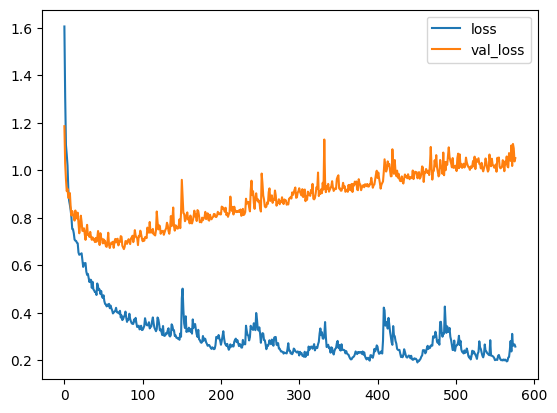

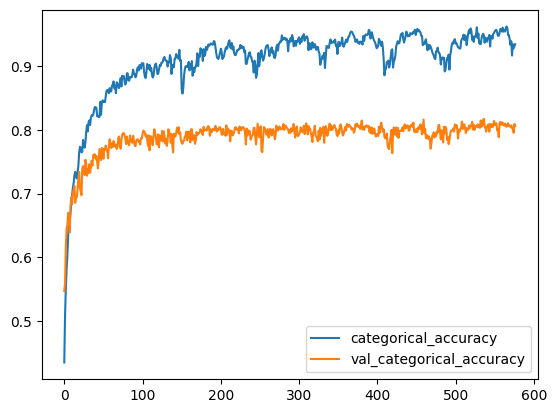

In [68]:
# Plot the loss (accuracy) and validation loss (accuracy) functions

history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.2f}" + "\nBest Validation Accuracy: {:0.2f}" + "\nBest Train Loss: {:0.2f}" + 
       "\nBest Train Accuracy: {:0.2f}")\
      .format(history_df['val_loss'].min(), history_df['val_categorical_accuracy'].max(), history_df["loss"].min(), 
              history_df["categorical_accuracy"].max()))

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Text(0.5, 25.722222222222214, 'Predicted label')

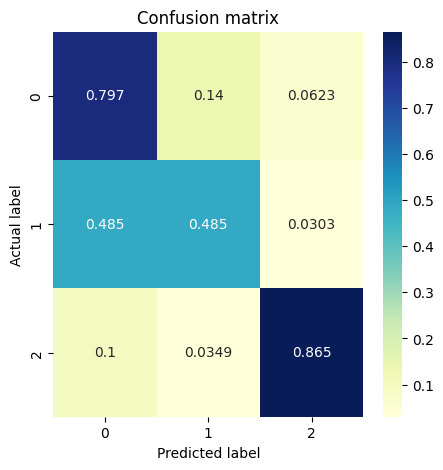

In [69]:
from sklearn.metrics import confusion_matrix

# Make predictions and decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(model.predict(X_test))]
# True mic values in string format
mics_test = [str(item[0]) for item in encoder.inverse_transform(y_test)]
# Unique mic values
mics = [str(mic) for mic in sorted(mic_dframe[antibiotic].loc[pd.notnull(mic_dframe[antibiotic])].unique())]
# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [70]:

### Teste com XGBoost 

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

XGBmodel = XGBClassifier(learning_rate = 0.1, 
                        eval_metric=["error", "logloss"], 
                        min_split_loss=0,
                        max_depth=6)

eval_set = [(X_train, y_train), (X_test, y_test)]
history = XGBmodel.fit(X_train, y_train, eval_set=eval_set, verbose=0)
y_pred = XGBmodel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Validation accuracy: " + str(accuracy))

Validation accuracy: 0.7411764705882353


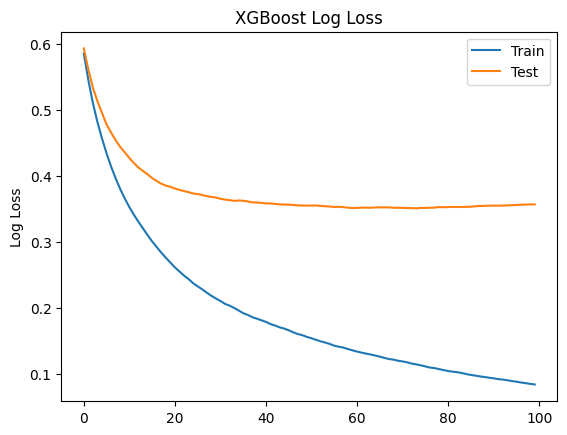

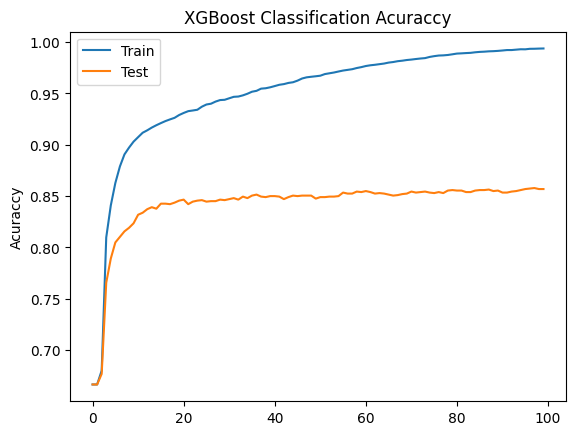

In [71]:
# Plot

results = XGBmodel.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

# plot classification error
fig, ax = plt.subplots()

for i in range(0, len(results["validation_0"]["error"])):
    results["validation_0"]["error"][i] = 1 - results["validation_0"]["error"][i]
    
for i in range(0, len(results["validation_1"]["error"])):
    results["validation_1"]["error"][i] = 1 - results["validation_1"]["error"][i]
    
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Acuraccy")
plt.title("XGBoost Classification Acuraccy")
plt.show()

Text(0.5, 25.722222222222214, 'Predicted label')

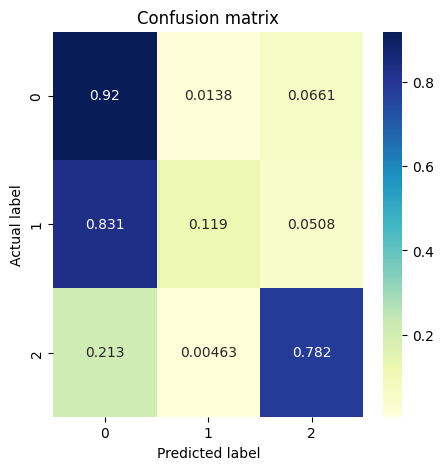

In [72]:

# Decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]

# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [73]:
# Teste Com Random Forest

from sklearn.ensemble import RandomForestClassifier

RFCmodel = RandomForestClassifier(n_estimators=128, 
                                  criterion="log_loss",
                                  max_depth=300,
                                  random_state=0,
                                  min_samples_leaf=4,
                                  max_features="sqrt",
                                  min_samples_split=2,
                                  verbose=0
                                  )

RFCmodel.fit(X_train, y_train)
y_pred = RFCmodel.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Validation accuracy: " + str(accuracy))

Validation accuracy: 0.6852941176470588


Text(0.5, 25.722222222222214, 'Predicted label')

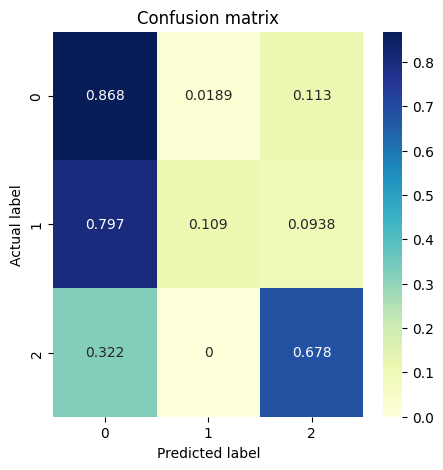

In [74]:
# Decode the OneHot
mics_pred = [str(item[0]) for item in encoder.inverse_transform(y_pred)]

# Compute the confusion matrix
cm = confusion_matrix(mics_test, mics_pred, normalize='true', labels=mics)
# Plot the cm
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='.3g', cmap="YlGnBu")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')